<a href="https://colab.research.google.com/github/arminsoltan/mohaymen/blob/main/Phase02/RNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

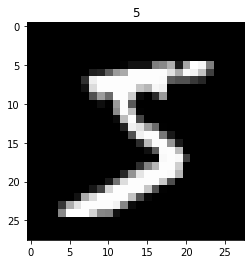

In [18]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0], cmap='gray')
plt.title("{}".format(train_data.targets[0]))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


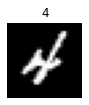

In [19]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(train_data), size=(1,)).item()
  img, label = train_data[sample_idx]
  figure.add_subplot(rows, cols, 1)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [20]:
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}


In [21]:
from torch import nn
import torch.nn.functional as F

In [22]:
sequence_length = 28
input_size = 28
hidden_size = 28
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [23]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    out, hidden = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device).to(device)

In [24]:
loss_func = nn.CrossEntropyLoss()

In [25]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [26]:
from tqdm import tqdm
def train(num_epochs, model, loaders):
  print("num_epochs: {}".format(num_epochs))
  print("model: {}".format(model))
  print("{}: {}".format(loaders['train'], loaders['test']))

  model.train()
  for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(loaders['train']):
      images = images.reshape(-1, sequence_length, input_size).to(device)
      labels = labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = loss_func(outputs, labels)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

In [27]:
model.train()
train(num_epochs, model, loaders)
model.eval()
with torch.no_grad():
  correct = 0 
  total = 0
  for images, labels in loaders['test']:
    images = images.reshape(-1, sequence_length, input_size).to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()

print("Test Accuracy of the model on the 10000 test images: {:.2f}".format(100 * correct / total))

  0%|          | 0/2 [00:00<?, ?it/s]

num_epochs: 2
model: RNN(
  (lstm): LSTM(28, 28, num_layers=2, batch_first=True)
  (fc): Linear(in_features=28, out_features=10, bias=True)
)
<torch.utils.data.dataloader.DataLoader object at 0x7f95573e2790>: <torch.utils.data.dataloader.DataLoader object at 0x7f95573e26d0>


100%|██████████| 2/2 [00:41<00:00, 20.68s/it]


Test Accuracy of the model on the 10000 test images: 97.30
